2021.07.05 臭氧預警 複迴歸方法

1. 讀取sample data(2018~2020，全年度)
    - 北: 新店、板橋、古亭
    - 中: 南投、竹山、埔里
    - 南: 屏東、潮州、小港
2. 變數(y=O3八小每日最大值)
    - x=O3小時值每日最大值 + 當日0點CO小時值(OR 當日0\~7點CO累積值 OR 當日0\~3 vs 5~7點CO提升比率)
    - (ex:南投站) x=O3小時值每日最大值 + 彰化、線西、沙鹿、大里站的O3小時值、O3前3小時平均?
    - (未來)+光化測站資料
3. Model (單變數v.s.多元線性迴歸)
    - sklearn.linear_model
    - 當年度 與 下年度驗證
4. 分鐘值 與 小時值
    - 疊圖比較 

In [49]:
import pandas as pd
import numpy as np  

# from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import metrics

import sys
sys.path.append('G:\我的雲端硬碟\python')
from polib.CsvEngn import *

import seaborn as sns
sns.set(style="darkgrid")

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']  
mpl.rcParams['axes.unicode_minus'] = False

import datetime
import math

# EDA

## 讀檔

In [2]:
bak_file_path = r"G:\我的雲端硬碟\python\output\0705\AQI_rowdata_20210705_11.21.18.pkl"
df = read_data_dir_fPathExt(bak_file_path)
# df.head()

  >> 讀取:: G:\我的雲端硬碟\python\output\0705\AQI_rowdata_20210705_11.21.18.pkl


In [3]:
# 篩選測站 & 篩選年分
site_lst = ["新店", "板橋", "古亭", "南投","竹山","埔里", "屏東","潮州","小港"]
year_min_max = [2018,2020]
pic_mask = (df["SiteName"].isin(site_lst)) & (df["DataCreationDate"].dt.year>=year_min_max[0]) & (df["DataCreationDate"].dt.year<=year_min_max[1])
df_pic = df[pic_mask].reset_index(drop=True)
df_pic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244152 entries, 0 to 244151
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   index             244152 non-null  int64         
 1   SiteName          244152 non-null  object        
 2   County            244152 non-null  object        
 3   AQI               240758 non-null  float64       
 4   Pollutant         129506 non-null  object        
 5   Status            243914 non-null  object        
 6   SO2               237985 non-null  float64       
 7   CO                239670 non-null  float64       
 8   O3                239046 non-null  float64       
 9   O3_8hr            241872 non-null  float64       
 10  PM10              237085 non-null  float64       
 11  PM2.5             233989 non-null  float64       
 12  NO2               236667 non-null  float64       
 13  NOx               236668 non-null  float64       
 14  NO  

In [83]:
# 移除遺漏值
df_pic.dropna(subset=["O3_8hr", "O3"], inplace=True)

In [5]:
# 合併 冷熱季 欄位


## 變數

In [84]:
#定義實際超標門檻值
exceed_value_real = 71 #實際超標門檻值(臭氧橘警71)
df_pic.loc[:,"O3_8hr_max"] = df_pic.loc[:,["SiteName","date","O3_8hr"]].groupby(by=["SiteName","date"]).transform(max).values
df_pic.loc[:,"is_exceed_date"] = df_pic.loc[:,"O3_8hr_max"] >= exceed_value_real

# 抓出超標時間點，合併回df_pic
df_pic_real_exceed_time = df_pic[df_pic["O3_8hr"]>=exceed_value_real][["SiteName","date","DataCreationDate"]].groupby(
                                                            ["SiteName","date"], as_index=False).min()
df_pic_real_exceed_time.loc[:,"real_exceed_hour"] = df_pic_real_exceed_time.loc[:,"DataCreationDate"].dt.hour
df_pic = df_pic.merge(df_pic_real_exceed_time[["SiteName","date","real_exceed_hour"]], how="left", on=["SiteName","date"])

In [85]:
# 計算每日O3_8hr、O3最大值
cols = ["O3_8hr","O3"]
gp_cols = ["SiteName","date"]
df_daily_max = df_pic[gp_cols+cols].groupby(by=gp_cols, as_index=False).max()
df_daily_max.rename(columns={"O3_8hr":"O3_8hr_max", "O3":"O3_max"}, inplace=True)

In [86]:
df_daily_max["date"].nunique()

1094

In [87]:
# 相關性
df_daily_max.corr(method ='pearson')

,O3_8hr_max,O3_max
O3_8hr_max,1.000000,0.939707
O3_max,0.939707,1.000000


In [88]:
# df_result
df_result = df_daily_max.copy(deep=True)

### 監測因子相關

#### 每日0點 小時值

In [89]:
object_lst = ["CO", "NOx","NO","NO2","SO2"]

In [90]:
time = 0

# df_result 重置
df_result = df_daily_max.copy(deep=True)

# 取每日0點 CO小時值
mask = (df_pic["DataCreationDate"].dt.hour==time)

# 合併 df_result
for obj in object_lst:
    df_result = df_result.merge(df_pic.loc[mask, ["SiteName","date", obj]], how="left", on=["SiteName","date"])
    df_result.rename(columns={obj:f"{obj}_at{time}"}, inplace=True)

df_result.drop_duplicates(keep="first", inplace=True) # 去重複
df_result.head()

,SiteName,date,O3_8hr_max,O3_max,CO_at0,NOx_at0,NO_at0,NO2_at0,SO2_at0
0,南投,2018-01-01,45.0,58.0,0.0,18.0,0.0,18.0,1.0
1,南投,2018-01-02,41.0,54.0,0.0,26.0,2.0,24.0,2.0
2,南投,2018-01-03,53.0,79.0,0.0,22.0,2.0,20.0,2.0
3,南投,2018-01-04,30.0,45.0,0.0,33.0,3.0,30.0,5.0
4,南投,2018-01-05,7.0,15.0,0.0,20.0,1.0,18.0,4.0


In [91]:
# 整合成 df_pic1
df_pic_1 = df_pic.merge(df_result.drop(columns=["O3_8hr_max","O3_max"]), how="left", on=["SiteName","date"])
df_pic_1.columns

Index(['index', 'SiteName', 'County', 'AQI', 'Pollutant', 'Status', 'SO2',
       'CO', 'O3', 'O3_8hr', 'PM10', 'PM2.5', 'NO2', 'NOx', 'NO', 'WindSpeed',
       'WindDirec', 'DataCreationDate', 'Unit', 'CO_8hr', 'PM2.5_AVG',
       'PM10_AVG', 'SO2_AVG', 'Longitude', 'Latitude', 'SiteId', 'date',
       'O3_8hr_max', 'is_exceed_date', 'real_exceed_hour', 'CO_at0', 'NOx_at0',
       'NO_at0', 'NO2_at0', 'SO2_at0'],
      dtype='object')

O3_8hr_max    1.000000
CO_at0       -0.047030
NOx_at0      -0.011054
NO_at0       -0.140771
NO2_at0       0.061867
SO2_at0      -0.023718
Name: O3_8hr_max, dtype: float64


<AxesSubplot:>

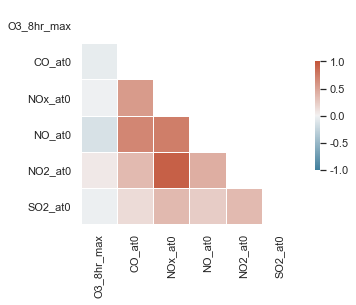

In [92]:
# 相關性 每日0點  相關性太低 
corr = df_result.drop(columns=["O3_max"]).corr(method ='pearson')
print(corr["O3_8hr_max"])

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

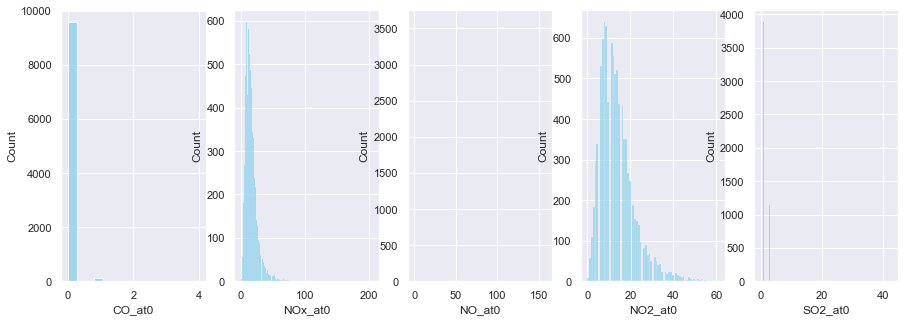

In [93]:
# 畫出直方圖

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, len(object_lst), figsize=(15, 5))

for idx, col in enumerate(object_lst):
    sns.histplot(data=df_result, x=f"{col}_at{time}", kde=False, color="skyblue", ax=axs[idx])

plt.show()

#### 每日7點 平均值

In [94]:
objectAVG_lst = ["CO_8hr","SO2_AVG"]

In [95]:
time = 7

# df_result 重置
df_result = df_daily_max.copy(deep=True)

# 取每日7點 CO小時值
mask = (df_pic["DataCreationDate"].dt.hour==time)

# 合併 df_result
for obj in objectAVG_lst:
    df_result = df_result.merge(df_pic.loc[mask, ["SiteName","date", obj]], how="left", on=["SiteName","date"])
    df_result.rename(columns={obj:f"{obj}_at{time}"}, inplace=True)

df_result.drop_duplicates(keep="first", inplace=True) # 去重複    
df_result.head()

,SiteName,date,O3_8hr_max,O3_max,CO_8hr_at7,SO2_AVG_at7
0,南投,2018-01-01,45.0,58.0,0.0,2.0
1,南投,2018-01-02,41.0,54.0,0.0,2.0
2,南投,2018-01-03,53.0,79.0,0.0,4.0
3,南投,2018-01-04,30.0,45.0,0.0,4.0
4,南投,2018-01-05,7.0,15.0,NaN,NaN


In [96]:
# 整合成 df_pic2
df_pic_2 = df_pic.merge(df_result.drop(columns=["O3_8hr_max"]), how="left", on=["SiteName","date"])
df_pic_2.columns

Index(['index', 'SiteName', 'County', 'AQI', 'Pollutant', 'Status', 'SO2',
       'CO', 'O3', 'O3_8hr', 'PM10', 'PM2.5', 'NO2', 'NOx', 'NO', 'WindSpeed',
       'WindDirec', 'DataCreationDate', 'Unit', 'CO_8hr', 'PM2.5_AVG',
       'PM10_AVG', 'SO2_AVG', 'Longitude', 'Latitude', 'SiteId', 'date',
       'O3_8hr_max', 'is_exceed_date', 'real_exceed_hour', 'O3_max',
       'CO_8hr_at7', 'SO2_AVG_at7'],
      dtype='object')

O3_8hr_max     1.000000
CO_8hr_at7    -0.029749
SO2_AVG_at7    0.002642
Name: O3_8hr_max, dtype: float64


<AxesSubplot:>

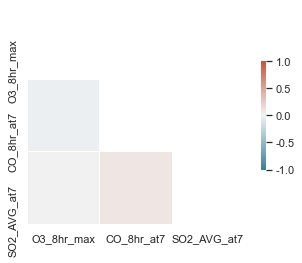

In [97]:
# 相關性 每日7點 CO_8hr 相關性太低 
corr = df_result.drop(columns=["O3_max"]).corr(method ='pearson')
print(corr["O3_8hr_max"])

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

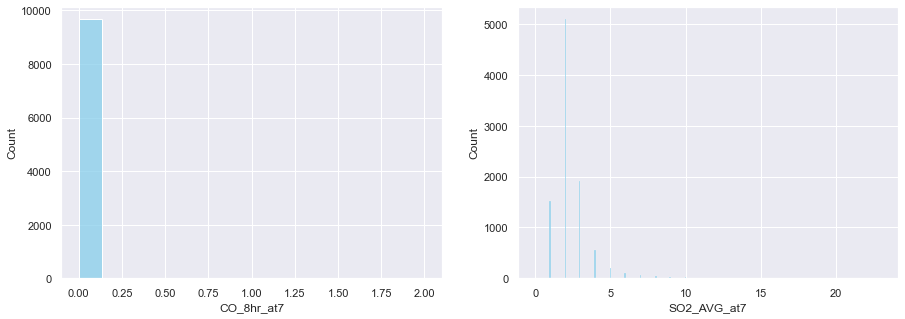

In [98]:
# 畫出直方圖

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, len(objectAVG_lst), figsize=(15, 5))

for idx, col in enumerate(objectAVG_lst):
    sns.histplot(data=df_result, x=f"{col}_at{time}", kde=False, color="skyblue", ax=axs[idx])

plt.show()

#### 每日0~7點 提升量(gradian)

In [99]:
objectGradian_lst = ["O3","CO", "NOx","NO","NO2","SO2"]

In [100]:
time_start = 0
time_end = 7

# df_result 重置
df_result = df_daily_max.copy(deep=True)

# 取每日0、7點 小時值
mask_start = (df_pic["DataCreationDate"].dt.hour==time_start)
mask_end = (df_pic["DataCreationDate"].dt.hour==time_end)

# 計算差值、百分比 gradian
for obj in objectGradian_lst:
    df_gradian = df_pic.loc[mask_start, ["SiteName","date", obj]].merge(
                        df_pic.loc[mask_end, ["SiteName","date", obj]], how="left", on=["SiteName","date"])
    df_gradian.rename(columns={f"{obj}_x":f"{obj}_at{time_start}", f"{obj}_y":f"{obj}_at{time_end}"}, inplace=True)
    
#     計算
    df_gradian.loc[:,f"{obj}_gradian_diff_{time_start}to{time_end}"] = df_gradian.loc[:,f"{obj}_at{time_end}"] - df_gradian.loc[:,f"{obj}_at{time_start}"]
#     df_gradian.loc[:,f"{obj}_gradian_ratio"] = (df_gradian.loc[:,f"{obj}_gradian_diff"] / df_gradian.loc[:,f"{obj}_at{time_end}"])*100
#     去除重複 (因取兩個時間點，在串資料時會*2)
    df_gradian.drop_duplicates(keep="first", inplace=True)
    df_result = df_result.merge(df_gradian[["SiteName","date",f"{obj}_gradian_diff_{time_start}to{time_end}"]], how="left", on=["SiteName","date"])

df_result.drop_duplicates(keep="first", inplace=True) # 去重複
df_result.head()

,SiteName,date,O3_8hr_max,O3_max,O3_gradian_diff_0to7,CO_gradian_diff_0to7,NOx_gradian_diff_0to7,NO_gradian_diff_0to7,NO2_gradian_diff_0to7,SO2_gradian_diff_0to7
0,南投,2018-01-01,45.0,58.0,-6.0,0.0,3.0,1.0,1.0,0.0
1,南投,2018-01-02,41.0,54.0,-2.0,0.0,4.0,15.0,-11.0,-1.0
2,南投,2018-01-03,53.0,79.0,-3.0,0.0,-1.0,0.0,-2.0,-2.0
3,南投,2018-01-04,30.0,45.0,0.0,0.0,-5.0,6.0,-12.0,-5.0
4,南投,2018-01-05,7.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
df_pic.columns

Index(['index', 'SiteName', 'County', 'AQI', 'Pollutant', 'Status', 'SO2',
       'CO', 'O3', 'O3_8hr', 'PM10', 'PM2.5', 'NO2', 'NOx', 'NO', 'WindSpeed',
       'WindDirec', 'DataCreationDate', 'Unit', 'CO_8hr', 'PM2.5_AVG',
       'PM10_AVG', 'SO2_AVG', 'Longitude', 'Latitude', 'SiteId', 'date',
       'O3_8hr_max', 'is_exceed_date', 'real_exceed_hour'],
      dtype='object')

In [102]:
# 整合成 df_pic3
df_pic_3 = df_pic.merge(df_result.drop(columns=["O3_8hr_max","O3_max"]), how="left", on=["SiteName","date"])
df_pic_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238667 entries, 0 to 238666
Data columns (total 36 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   index                  238667 non-null  int64         
 1   SiteName               238667 non-null  object        
 2   County                 238667 non-null  object        
 3   AQI                    237189 non-null  float64       
 4   Pollutant              127659 non-null  object        
 5   Status                 238667 non-null  object        
 6   SO2                    235984 non-null  float64       
 7   CO                     237436 non-null  float64       
 8   O3                     238667 non-null  float64       
 9   O3_8hr                 238667 non-null  float64       
 10  PM10                   234747 non-null  float64       
 11  PM2.5                  231601 non-null  float64       
 12  NO2                    234718 non-null  floa

O3_8hr_max               1.000000
O3_gradian_diff_0to7    -0.373161
CO_gradian_diff_0to7     0.041500
NOx_gradian_diff_0to7    0.041349
NO_gradian_diff_0to7     0.024120
NO2_gradian_diff_0to7    0.041825
SO2_gradian_diff_0to7   -0.017341
Name: O3_8hr_max, dtype: float64


<AxesSubplot:>

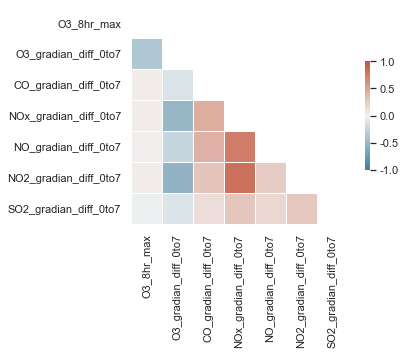

In [103]:
# 相關性 每日gradian 相關性太低 
corr = df_result.drop(columns=["O3_max"]).corr(method ='pearson')
print(corr["O3_8hr_max"])

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

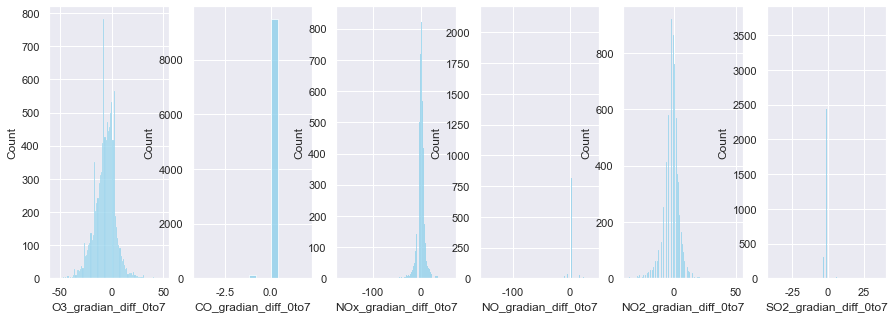

In [104]:
# 畫出直方圖
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, len(objectGradian_lst), figsize=(15, 5))

for idx, col in enumerate(objectGradian_lst):
    sns.histplot(data=df_result, x=f"{col}_gradian_diff_{time_start}to{time_end}", kde=False, color="skyblue", ax=axs[idx])

plt.show()

#### 每日7~12點 提升量(gradian)

In [141]:
objectGradian_lst = ["O3","CO", "NOx","NO","NO2","SO2"]

In [142]:
time_start = 7
time_end = 12

# df_result 重置
df_result = df_daily_max.copy(deep=True)

# 取每日0、7點 小時值
mask_start = (df_pic["DataCreationDate"].dt.hour==time_start)
mask_end = (df_pic["DataCreationDate"].dt.hour==time_end)

# 計算差值、百分比 gradian
for obj in objectGradian_lst:
    df_gradian = df_pic.loc[mask_start, ["SiteName","date", obj]].merge(
                        df_pic.loc[mask_end, ["SiteName","date", obj]], how="left", on=["SiteName","date"])
    df_gradian.rename(columns={f"{obj}_x":f"{obj}_at{time_start}", f"{obj}_y":f"{obj}_at{time_end}"}, inplace=True)
    
#     計算
    df_gradian.loc[:,f"{obj}_gradian_diff_{time_start}to{time_end}"] = df_gradian.loc[:,f"{obj}_at{time_end}"] - df_gradian.loc[:,f"{obj}_at{time_start}"]
#     df_gradian.loc[:,f"{obj}_gradian_ratio"] = (df_gradian.loc[:,f"{obj}_gradian_diff"] / df_gradian.loc[:,f"{obj}_at{time_end}"])*100
#     去除重複 (因取兩個時間點，在串資料時會*2)
    df_gradian.drop_duplicates(keep="first", inplace=True)
    df_result = df_result.merge(df_gradian[["SiteName","date",f"{obj}_gradian_diff_{time_start}to{time_end}"]], how="left", on=["SiteName","date"])

df_result.drop_duplicates(keep="first", inplace=True) # 去重複    
df_result.head()

,SiteName,date,O3_8hr_max,O3_max,O3_gradian_diff_7to12,CO_gradian_diff_7to12,NOx_gradian_diff_7to12,NO_gradian_diff_7to12,NO2_gradian_diff_7to12,SO2_gradian_diff_7to12
0,南投,2018-01-01,45.0,58.0,22.0,0.0,0.0,3.0,-2.0,1.0
1,南投,2018-01-02,41.0,54.0,38.0,0.0,-6.0,-12.0,6.0,3.0
2,南投,2018-01-03,53.0,79.0,NaN,NaN,NaN,NaN,NaN,NaN
3,南投,2018-01-04,30.0,45.0,32.0,0.0,-4.0,-6.0,3.0,2.0
4,南投,2018-01-05,7.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
# 整合成 df_pic4
df_pic_4 = df_pic.merge(df_result.drop(columns=["O3_8hr_max","O3_max"]), how="left", on=["SiteName","date"])
df_pic_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238667 entries, 0 to 238666
Data columns (total 36 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   index                   238667 non-null  int64         
 1   SiteName                238667 non-null  object        
 2   County                  238667 non-null  object        
 3   AQI                     237189 non-null  float64       
 4   Pollutant               127659 non-null  object        
 5   Status                  238667 non-null  object        
 6   SO2                     235984 non-null  float64       
 7   CO                      237436 non-null  float64       
 8   O3                      238667 non-null  float64       
 9   O3_8hr                  238667 non-null  float64       
 10  PM10                    234747 non-null  float64       
 11  PM2.5                   231601 non-null  float64       
 12  NO2                     234718

O3_8hr_max                1.000000
O3_gradian_diff_7to12     0.688322
CO_gradian_diff_7to12    -0.046524
NOx_gradian_diff_7to12   -0.236128
NO_gradian_diff_7to12    -0.159044
NO2_gradian_diff_7to12   -0.225948
SO2_gradian_diff_7to12    0.109203
Name: O3_8hr_max, dtype: float64


<AxesSubplot:>

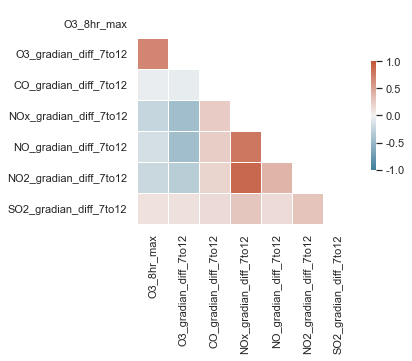

In [144]:
# 相關性 每日gradian 相關性太低 
corr = df_result.drop(columns=["O3_max"]).corr(method ='pearson')
print(corr["O3_8hr_max"])

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

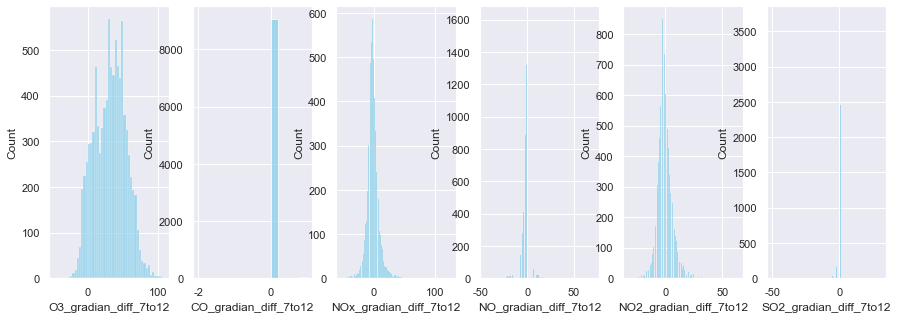

In [109]:
# 畫出直方圖
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, len(objectGradian_lst), figsize=(15, 5))

for idx, col in enumerate(objectGradian_lst):
    sns.histplot(data=df_result, x=f"{col}_gradian_diff_{time_start}to{time_end}", kde=False, color="skyblue", ax=axs[idx])

plt.show()

#### 每日小時值 最大值

In [110]:
objectMax_lst = ["CO", "NOx","NO","NO2","SO2"]

In [111]:

# df_result 重置
df_result = df_daily_max.copy(deep=True)

# 計算每日小時值 最大值
gp_cols = ["SiteName","date"]
df_daily_max_others = df_pic[gp_cols+objectMax_lst].groupby(by=gp_cols, as_index=False).max()
for col in objectMax_lst:
    df_daily_max_others.rename(columns={col:f"{col}_max"}, inplace=True)
    df_result = df_result.merge(df_daily_max_others[["SiteName","date",f"{col}_max"]], how="left", on=["SiteName","date"])

df_result.drop_duplicates(keep="first", inplace=True) # 去重複    
df_result.head()

,SiteName,date,O3_8hr_max,O3_max,CO_max,NOx_max,NO_max,NO2_max,SO2_max
0,南投,2018-01-01,45.0,58.0,0.0,35.0,10.0,32.0,3.0
1,南投,2018-01-02,41.0,54.0,1.0,54.0,38.0,41.0,8.0
2,南投,2018-01-03,53.0,79.0,1.0,45.0,4.0,42.0,7.0
3,南投,2018-01-04,30.0,45.0,0.0,55.0,25.0,42.0,5.0
4,南投,2018-01-05,7.0,15.0,0.0,54.0,28.0,33.0,4.0


In [112]:
# 整合成 df_pic5
df_pic_5 = df_pic.merge(df_result.drop(columns=["O3_8hr_max","O3_max"]), how="left", on=["SiteName","date"])
df_pic_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238619 entries, 0 to 238618
Data columns (total 35 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   index             238619 non-null  int64         
 1   SiteName          238619 non-null  object        
 2   County            238619 non-null  object        
 3   AQI               237141 non-null  float64       
 4   Pollutant         127619 non-null  object        
 5   Status            238619 non-null  object        
 6   SO2               235936 non-null  float64       
 7   CO                237389 non-null  float64       
 8   O3                238619 non-null  float64       
 9   O3_8hr            238619 non-null  float64       
 10  PM10              234699 non-null  float64       
 11  PM2.5             231553 non-null  float64       
 12  NO2               234670 non-null  float64       
 13  NOx               234670 non-null  float64       
 14  NO  

O3_8hr_max    1.000000
O3_max        0.939707
CO_max       -0.089034
NOx_max      -0.099744
NO_max       -0.201802
NO2_max       0.040839
SO2_max       0.063399
Name: O3_8hr_max, dtype: float64


<AxesSubplot:>

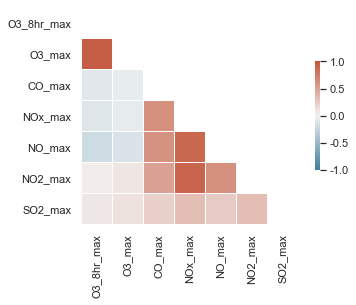

In [116]:
# 相關性 每日MAX 相關性太低 除了O3 MAX
corr = df_result.corr(method ='pearson')
print(corr["O3_8hr_max"])

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

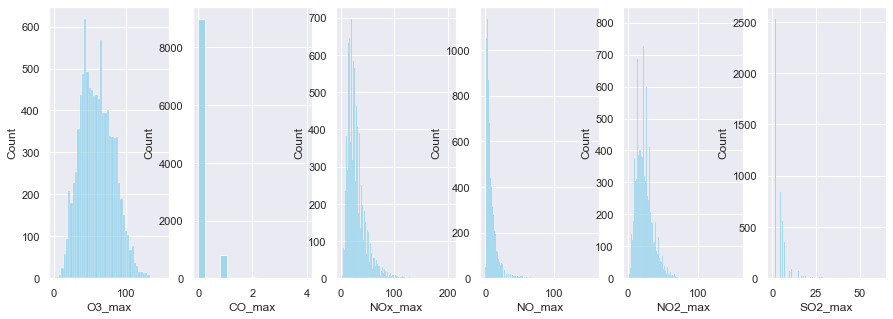

In [115]:
# 畫出直方圖
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, len(objectGradian_lst), figsize=(15, 5))

for idx, col in enumerate(objectGradian_lst):
    sns.histplot(data=df_result, x=f"{col}_max", kde=False, color="skyblue", ax=axs[idx])

plt.show()

### 上風處測站相關

- 中: 沙鹿、線西、 彰化、員林 > 南投

In [136]:
# 篩選測站 & 篩選年分
site_lst = ["南投", "沙鹿","西屯","忠明","豐原", "線西", "彰化","彰化(員林)","二林"]
year_min_max = [2018,2020]
pic_mask = (df["SiteName"].isin(site_lst)) & (df["DataCreationDate"].dt.year>=year_min_max[0]) & (df["DataCreationDate"].dt.year<=year_min_max[1])
df_pic_for_fornt = df[pic_mask].reset_index(drop=True)
df_pic_for_fornt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219951 entries, 0 to 219950
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   index             219951 non-null  int64         
 1   SiteName          219951 non-null  object        
 2   County            219951 non-null  object        
 3   AQI               217235 non-null  float64       
 4   Pollutant         112354 non-null  object        
 5   Status            219810 non-null  object        
 6   SO2               214631 non-null  float64       
 7   CO                216169 non-null  float64       
 8   O3                215623 non-null  float64       
 9   O3_8hr            218108 non-null  float64       
 10  PM10              213080 non-null  float64       
 11  PM2.5             211361 non-null  float64       
 12  NO2               213636 non-null  float64       
 13  NOx               213639 non-null  float64       
 14  NO  

In [137]:
target_site = site_lst[0]
front_site_lst = site_lst[1:]
y = "O3_8hr"
x = "O3"

In [138]:
mask_y = df_pic_for_fornt["SiteName"].isin([target_site])
datay = df_pic_for_fornt.loc[mask_y, y].reset_index(drop=True)
# datay.head()

In [139]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datay.corr(datax.shift(-lag)) # x往前推

In [140]:
front = 7
range_setting = range(front,1,-1)

In [141]:
plot_dict = {}
for f in front_site_lst:
    mask_x = df_pic_for_fornt["SiteName"].isin([f])
    print(f)
    datax = df_pic_for_fornt.loc[mask_x, x].reset_index(drop=True)
    a = [crosscorr(datax, datay, lag=i) for i in range_setting]
    print(a)
    plot_dict[f] = a

沙鹿
[0.4273921221922654, 0.42830862379096096, 0.4108577423650703, 0.37242222284465637, 0.31658430428548984, 0.24961443652522913]
西屯
[-0.1257673633267589, -0.08922760671892997, -0.026403476441387113, 0.06115541426662743, 0.17061513293997058, 0.2973927672075268]
忠明
[-0.13794524062704078, -0.12593501402010643, -0.09494491814519986, -0.038903666749278094, 0.043479758295585216, 0.14953585100340086]
豐原
[-0.10041617137236225, -0.06541204332759483, -0.00878069137150634, 0.07403073000105936, 0.17732515170602497, 0.29543697036105704]
線西
[-0.07066488653030105, -0.027594627669991236, 0.03932954848645017, 0.12093679132577821, 0.21913371964272882, 0.32840492700777224]
彰化
[-0.08868228447625083, -0.050946011795515625, 0.015056571467230065, 0.09862013641280065, 0.20078754028997806, 0.3101901615618162]
彰化(員林)
[-0.033733191494596394, -0.0013580213635714321, 0.04053212813580412, 0.1011979927996178, 0.18721809034141007, 0.25911346046192907]
二林
[-0.1423830270828658, -0.10395730755737886, -0.03447632846590916

Text(0.5, 1.0, '南投站 周遭測站 O3小時值 時間相關性')

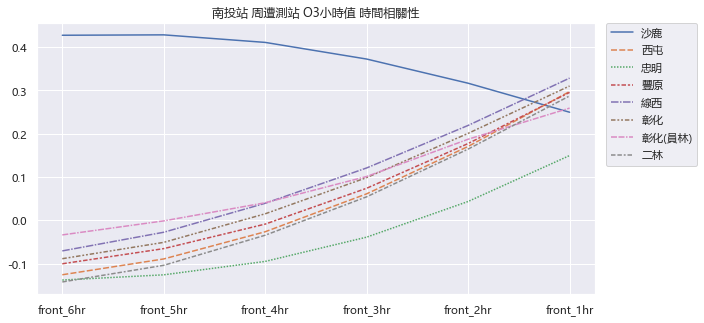

In [149]:
plt.figure(figsize=(10,5))
g = sns.lineplot(data=plot_dict)
g.set_xticks(range(front-1)) # <--- set the ticks first
g.set_xticklabels([f"front_{i-1}hr" for i in range_setting])
g.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
g.set_title(f"{target_site}站 周遭測站 O3小時值 時間相關性")


>可嘗試以 **沙鹿測站**作為**南投測站**的有效上風測站(先行指標)

# Model

以2018年建模(train)、2019年驗證(test)

## (原)單變數迴歸

In [39]:
df_result["SiteName"].unique()[0:1]

array(['南投'], dtype=object)

>> Mean Absolute Error: 3.5014867701450427
>> Root Mean Squared Error: 4.62753151800335


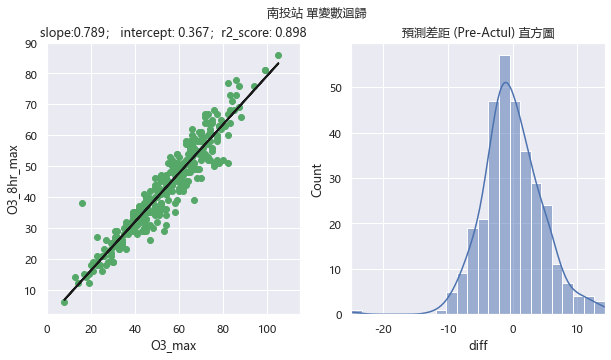

In [162]:
for s in df_result["SiteName"].unique()[0:1]:
    # mask
    mask_train = (df_result["SiteName"].isin([s])) & (df_result["date"].apply(lambda d: d.year)==2018)
    mask_test_self = (df_pic["SiteName"].isin([s])) & (df_pic["date"].apply(lambda d: d.year)==2018)
    mask_test_next = (df_pic["SiteName"].isin([s])) & (df_pic["date"].apply(lambda d: d.year)==2019)
    
    #split dataset
    #     for model
    X_train = df_result[mask_train]['O3_max'].values.reshape(-1,1) 
    y_train = df_result[mask_train]['O3_8hr_max'].values.reshape(-1,1) 

    #  for test_self
    X_test_self = df_pic[mask_test_self]['O3'].values.reshape(-1,1) 
    y_test_self = df_pic[mask_test_self]['O3_8hr'].values.reshape(-1,1)
    
    # for test_next
    X_test_next = df_pic[mask_test_next]['O3'].values.reshape(-1,1) 
    y_test_next = df_pic[mask_test_next]['O3_8hr'].values.reshape(-1,1)
    
    # model
    reg = LinearRegression(fit_intercept=True)  
    reg.fit(X_train, y_train) # 訓練模型
    y_train_pred = reg.predict(X_train) # 預測
    
    # Plot outputs
    fig, axes = plt.subplots(1, 2, sharex=False, figsize=(10,5))
    fig.suptitle(f'{s}站 單變數迴歸\n\n\n')
    
    axes[0].scatter(X_train, y_train,  color='g')
    axes[0].plot(X_train, y_train_pred, color='k', linewidth=2)
    axes[0].set_xlim(0, X_train.max()+10)
    axes[0].set_xlabel('O3_max')
    axes[0].set_ylabel('O3_8hr_max')
    axes[0].set_title(f"slope:{round(reg.coef_[0][0],3)}； intercept: {round(reg.intercept_[0],3)}；r2_score: {round(r2_score(y_train, y_train_pred),3)}")
    
    # diff hist()
    single_reg_diff = pd.DataFrame({'Actual': y_train.flatten(), 'Predicted': y_train_pred.flatten()})
    single_reg_diff.loc[:, "diff"] = single_reg_diff.loc[: ,"Predicted"] - single_reg_diff.loc[: ,"Actual"]
    sns.histplot(data=single_reg_diff, x="diff", kde=True, ax=axes[1])
    axes[1].set_xlim(single_reg_diff.loc[:, "diff"].min(), single_reg_diff.loc[:, "diff"].max())
    axes[1].set_title(f"預測差距 (Pre-Actul) 直方圖")
    
    print('>> Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_train_pred))  
#     print('>> Mean Squared Error:', metrics.mean_squared_error(y_train, y_train_pred))  
    print('>> Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))

### 當年度驗證 self

In [163]:
# 以模型預測每小時資料
y_test_self_pred = reg.predict(X_test_self)

# 定義預測超標門檻值
exceed_value_pred = 71 # 預測超標門檻值

# 取用小時值資料
df_self = df_pic[mask_test_self].reset_index(drop=True).copy(deep=True)
df_self.loc[:,"y_pred"] = y_test_self_pred
df_self.loc[:,f"is_y_pred_ge_{exceed_value_pred}"] = (y_test_self_pred>=exceed_value_pred)

# 挑選出每天最早預測超標的小時資料、若皆無預測超標，則會為0時的資料
df_self = df_self.sort_values(
            by=["date", f"is_y_pred_ge_{exceed_value_pred}", "DataCreationDate"],
                ascending=[1,0,1]).drop_duplicates(subset=["date"], keep="first")


# 驗證對錯>>混淆矩陣
# metrics.confusion_matrix(y_true, y_pred)
# (tn, fp, fn, tp)
cm = metrics.confusion_matrix(df_self["is_exceed_date"].values, df_self[f"is_y_pred_ge_{exceed_value_pred}"].values).ravel()

print(f">>預測目標門檻值: {exceed_value_pred}\n")
print(f">> TN: {cm[0]}\n>> FP: {cm[1]}\n>> FN: {cm[2]}\n>> TP: {cm[3]}\n")
print(f">> 預警成功率: {round((cm[3]/(cm[2]+cm[3])),3)}\n>> 假警報率: {round((cm[1]/(cm[1]+cm[3])),3)}\n")


# 計算 TP  預警時間、提早時數
mask_TP = (df_self["is_exceed_date"].isin([True])) &(df_self[f"is_y_pred_ge_{exceed_value_pred}"].isin([True]))

print(f">> 預警成功 發布時間點 統計:\n時間點   次數\n{df_self[mask_TP]['DataCreationDate'].dt.hour.value_counts()}")
print(f">> 預警成功 提早時數 統計:\n提早時數   次數\n{((df_self[mask_TP]['real_exceed_hour']) -(df_self[mask_TP]['DataCreationDate'].dt.hour)).value_counts()}")

>>預測目標門檻值: 71

>> TN: 353
>> FP: 1
>> FN: 6
>> TP: 4

>> 預警成功率: 0.4
>> 假警報率: 0.2

>> 預警成功 發布時間點 統計:
時間點   次數
14    4
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
2.0    3
4.0    1
dtype: int64


### 下年度驗證 next

In [164]:
# 以模型預測每小時資料
y_test_next_pred = reg.predict(X_test_next)

# 定義預測超標門檻值
exceed_value_pred = 71 # 預測超標門檻值

# 取用小時值資料
df_next = df_pic[mask_test_next].reset_index(drop=True).copy(deep=True)
df_next.loc[:,"y_pred"] = y_test_next_pred
df_next.loc[:,f"is_y_pred_ge_{exceed_value_pred}"] = (y_test_next_pred>=exceed_value_pred)

# 挑選出每天最早預測超標的小時資料、若皆無預測超標，則會為0時的資料
df_next = df_next.sort_values(
            by=["date", f"is_y_pred_ge_{exceed_value_pred}", "DataCreationDate"],
                ascending=[1,0,1]).drop_duplicates(subset=["date"], keep="first")

# 驗證對錯>>混淆矩陣
# metrics.confusion_matrix(y_true, y_pred)
# (tn, fp, fn, tp)
cm = metrics.confusion_matrix(df_next["is_exceed_date"].values, df_next[f"is_y_pred_ge_{exceed_value_pred}"].values).ravel()

print(f">>預測目標門檻值: {exceed_value_pred}\n")
print(f">> TN: {cm[0]}\n>> FP: {cm[1]}\n>> FN: {cm[2]}\n>> TP: {cm[3]}\n")
print(f">> 預警成功率: {round((cm[3]/(cm[2]+cm[3])),3)}\n>> 假警報率: {round((cm[1]/(cm[1]+cm[3])),3)}\n")

# 計算 TP  預警時間、提早時數
mask_TP = (df_next["is_exceed_date"].isin([True])) &(df_next[f"is_y_pred_ge_{exceed_value_pred}"].isin([True]))

print(f">> 預警成功 發布時間點 統計:\n時間點   次數\n{df_next[mask_TP]['DataCreationDate'].dt.hour.value_counts()}")
print(f">> 預警成功 提早時數 統計:\n提早時數   次數\n{((df_next[mask_TP]['real_exceed_hour']) -(df_next[mask_TP]['DataCreationDate'].dt.hour)).value_counts()}")

>>預測目標門檻值: 71

>> TN: 330
>> FP: 1
>> FN: 11
>> TP: 11

>> 預警成功率: 0.5
>> 假警報率: 0.083

>> 預警成功 發布時間點 統計:
時間點   次數
14    4
13    3
15    3
12    1
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
2.0    5
3.0    4
4.0    2
dtype: int64


## 複迴歸測試

### 參數設定

In [145]:
# 變數設定
X_col_model = ['O3_max',"O3_gradian_diff_7to12"]
X_col_test = ['O3',"O3_gradian_diff_7to12"]
df_pic_for_model = df_pic_4.copy(deep=True)

In [146]:
# 刪除遺漏值
df_result.dropna(how='any', inplace=True)

print(f">> 刪除row數: {len(df_pic_for_model) - len(df_pic_for_model.dropna(subset=X_col_test, how='any'))}")
df_pic_for_model.dropna(subset=X_col_test, how='any', inplace=True)

df_pic_for_model.columns

>> 刪除row數: 11399


Index(['index', 'SiteName', 'County', 'AQI', 'Pollutant', 'Status', 'SO2',
       'CO', 'O3', 'O3_8hr', 'PM10', 'PM2.5', 'NO2', 'NOx', 'NO', 'WindSpeed',
       'WindDirec', 'DataCreationDate', 'Unit', 'CO_8hr', 'PM2.5_AVG',
       'PM10_AVG', 'SO2_AVG', 'Longitude', 'Latitude', 'SiteId', 'date',
       'O3_8hr_max', 'is_exceed_date', 'real_exceed_hour',
       'O3_gradian_diff_7to12', 'CO_gradian_diff_7to12',
       'NOx_gradian_diff_7to12', 'NO_gradian_diff_7to12',
       'NO2_gradian_diff_7to12', 'SO2_gradian_diff_7to12'],
      dtype='object')

>> X:['O3_max', 'O3_gradian_diff_7to12']
>> slope:[[0.69352921 0.11493844]]
>> intercept: 1.548
>> r2_score: 0.905

>> Mean Absolute Error: 3.3951601647948815
>> Root Mean Squared Error: 4.461839900600448


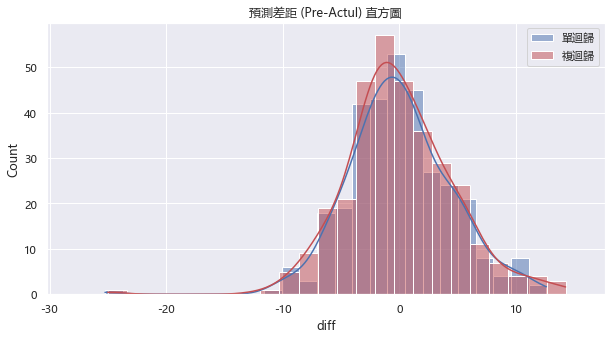

In [259]:
for s in df_result["SiteName"].unique()[0:1]:
    # mask
    mask_train = (df_result["SiteName"].isin([s])) & (df_result["date"].apply(lambda d: d.year)==2018)
    mask_test_self = (df_pic_for_model["SiteName"].isin([s])) & (df_pic_for_model["date"].apply(lambda d: d.year)==2018)
    mask_test_next = (df_pic_for_model["SiteName"].isin([s])) & (df_pic_for_model["date"].apply(lambda d: d.year)==2019)
    
    #split dataset
    #     for model
    X_train = df_result[mask_train][X_col_model].values
    y_train = df_result[mask_train]['O3_8hr_max'].values.reshape(-1,1) 

    #  for test_self
    X_test_self = df_pic_for_model[mask_test_self][X_col_test].values
    y_test_self = df_pic_for_model[mask_test_self]['O3_8hr'].values.reshape(-1,1)
    
    # for test_next
    X_test_next = df_pic_for_model[mask_test_next][X_col_test].values
    y_test_next = df_pic_for_model[mask_test_next]['O3_8hr'].values.reshape(-1,1)
    
    # model
    reg = LinearRegression(fit_intercept=True)  
    reg.fit(X_train, y_train) # 訓練模型
    y_train_pred = reg.predict(X_train) # 預測
    
    # Print outputs
    print(f">> X:{X_col_model}")
    print(f">> slope:{reg.coef_}")
    print(f">> intercept: {round(reg.intercept_[0],3)}")
    print(f">> r2_score: {round(r2_score(y_train, y_train_pred),3)}\n")
    
    
    # 單變數迴歸 diff: single_reg_diff
    
    # 複迴歸 diff: mutil_reg_diff
    mutil_reg_diff = pd.DataFrame({'Actual': y_train.flatten(), 'Predicted': y_train_pred.flatten()})
    mutil_reg_diff.loc[:, "diff"] = mutil_reg_diff.loc[: ,"Predicted"] - mutil_reg_diff.loc[: ,"Actual"]

    # 疊圖
    fig, ax = plt.subplots(figsize=(10,5))
    for idx, d in enumerate([mutil_reg_diff, single_reg_diff]):
        if idx==1:
            color = 'r'
            label = "複迴歸"
        else:
            color = 'b'
            label = "單迴歸"
            
        sns.histplot(data=d, x="diff" ,ax=ax, kde=True, color=color, label=label)
    ax.set_xlim(mutil_reg_diff.loc[:, "diff"].min()-5, mutil_reg_diff.loc[:, "diff"].max()+5)
    ax.legend()
    ax.set_title(f"預測差距 (Pre-Actul) 直方圖")
    
    print('>> Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_train_pred))  
#     print('>> Mean Squared Error:', metrics.mean_squared_error(y_train, y_train_pred))  
    print('>> Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))

### 當年度驗證 self 

In [167]:
# 當年度驗證

# 以模型預測每小時資料
y_test_self_pred = reg.predict(X_test_self)

# 定義預測超標門檻值
exceed_value_pred = 71 # 預測超標門檻值

# 取用小時值資料
df_self = df_pic_for_model[mask_test_self].reset_index(drop=True).copy(deep=True)
df_self.loc[:,"y_pred"] = y_test_self_pred
df_self.loc[:,f"is_y_pred_ge_{exceed_value_pred}"] = (y_test_self_pred>=exceed_value_pred)

# 挑選出每天最早預測超標的小時資料、若皆無預測超標，則會為0時的資料
df_self = df_self.sort_values(
            by=["date", f"is_y_pred_ge_{exceed_value_pred}", "DataCreationDate"],
                ascending=[1,0,1]).drop_duplicates(subset=["date"], keep="first")

# 驗證對錯>>混淆矩陣
# metrics.confusion_matrix(y_true, y_pred)
# (tn, fp, fn, tp)
cm = metrics.confusion_matrix(df_self["is_exceed_date"].values, df_self[f"is_y_pred_ge_{exceed_value_pred}"].values).ravel()
print(f">>預測目標門檻值: {exceed_value_pred}\n")
print(f">> TN: {cm[0]}\n>> FP: {cm[1]}\n>> FN: {cm[2]}\n>> TP: {cm[3]}\n")
print(f">> 預警成功率: {round((cm[3]/(cm[2]+cm[3])),3)}\n>> 假警報率: {round((cm[1]/(cm[1]+cm[3])),3)}\n")

# 計算 TP  預警時間、提早時數
mask_TP = (df_self["is_exceed_date"].isin([True])) &(df_self[f"is_y_pred_ge_{exceed_value_pred}"].isin([True]))

print(f">> 預警成功 發布時間點 統計:\n時間點   次數\n{df_self[mask_TP]['DataCreationDate'].dt.hour.value_counts()}")
print(f">> 預警成功 提早時數 統計:\n提早時數   次數\n{((df_self[mask_TP]['real_exceed_hour']) -(df_self[mask_TP]['DataCreationDate'].dt.hour)).value_counts()}")

>>預測目標門檻值: 71

>> TN: 334
>> FP: 0
>> FN: 6
>> TP: 4

>> 預警成功率: 0.4
>> 假警報率: 0.0

>> 預警成功 發布時間點 統計:
時間點   次數
14    4
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
2.0    3
4.0    1
dtype: int64


### 下年度驗證 next 

In [168]:
# 下年度驗證

# 以模型預測每小時資料
y_test_next_pred = reg.predict(X_test_next)

# 定義預測超標門檻值
exceed_value_pred = 71 # 預測超標門檻值

# 取用小時值資料
df_next = df_pic_for_model[mask_test_next].reset_index(drop=True).copy(deep=True)
df_next.loc[:,"y_pred"] = y_test_next_pred
df_next.loc[:,f"is_y_pred_ge_{exceed_value_pred}"] = (y_test_next_pred>=exceed_value_pred)

# 挑選出每天最早預測超標的小時資料、若皆無預測超標，則會為0時的資料
df_next = df_next.sort_values(
            by=["date", f"is_y_pred_ge_{exceed_value_pred}", "DataCreationDate"],
                ascending=[1,0,1]).drop_duplicates(subset=["date"], keep="first")

# 驗證對錯>>混淆矩陣
# metrics.confusion_matrix(y_true, y_pred)
# (tn, fp, fn, tp)
cm = metrics.confusion_matrix(df_next["is_exceed_date"].values, df_next[f"is_y_pred_ge_{exceed_value_pred}"].values).ravel()

print(f">>預測目標門檻值: {exceed_value_pred}\n")
print(f">> TN: {cm[0]}\n>> FP: {cm[1]}\n>> FN: {cm[2]}\n>> TP: {cm[3]}\n")
print(f">> 預警成功率: {round((cm[3]/(cm[2]+cm[3])),3)}\n>> 假警報率: {round((cm[1]/(cm[1]+cm[3])),3)}\n")

# 計算 TP  預警時間、提早時數
mask_TP = (df_next["is_exceed_date"].isin([True])) &(df_next[f"is_y_pred_ge_{exceed_value_pred}"].isin([True]))

print(f">> 預警成功 發布時間點 統計:\n時間點   次數\n{df_next[mask_TP]['DataCreationDate'].dt.hour.value_counts()}")
print(f">> 預警成功 提早時數 統計:\n提早時數   次數\n{((df_next[mask_TP]['real_exceed_hour']) -(df_next[mask_TP]['DataCreationDate'].dt.hour)).value_counts()}")

>>預測目標門檻值: 71

>> TN: 316
>> FP: 1
>> FN: 10
>> TP: 10

>> 預警成功率: 0.5
>> 假警報率: 0.091

>> 預警成功 發布時間點 統計:
時間點   次數
14    4
13    3
12    2
15    1
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
3.0    5
4.0    3
2.0    2
dtype: int64


### 檢查

In [187]:
# 檢查 超標次數 會因為變數值遺漏而缺漏 EX 4
mask = (df_pic_4["SiteName"].isin(["南投"])) & (df_pic_4["DataCreationDate"].dt.year==2019) & (df_pic_4["is_exceed_date"].isin([True]))
df_pic_4[mask].drop_duplicates(subset=["date"]).sort_values(by=["date"])[["date","O3_gradian_diff_7to12"]]

,date,O3_gradian_diff_7to12
120713,2019-07-17,NaN
115511,2019-08-22,58.0
115730,2019-08-23,81.0
116792,2019-08-28,57.0
104939,2019-09-02,NaN
106840,2019-09-11,55.0
107044,2019-09-12,66.0
109180,2019-09-22,52.0
109394,2019-09-23,64.0
109608,2019-09-24,70.0


In [197]:
# 檢查 細看
date_lst = [datetime.date(2019,7,17), datetime.date(2019,9,2)]
mask = (df_pic_4["SiteName"].isin(["南投"])) & (df_pic_4["date"].isin(date_lst)) 
df_pic_4[mask].sort_values(by=["DataCreationDate"])[["DataCreationDate","O3"]] # 原始資料缺值

,DataCreationDate,O3
120713,2019-07-17 17:00:00,82.0
120729,2019-07-17 19:00:00,72.0
120740,2019-07-17 20:00:00,57.0
120748,2019-07-17 21:00:00,43.0
120758,2019-07-17 22:00:00,38.0
120765,2019-07-17 23:00:00,35.0
104939,2019-09-02 00:00:00,11.0
104947,2019-09-02 01:00:00,7.0
104953,2019-09-02 02:00:00,8.0
104961,2019-09-02 03:00:00,6.0


- 以 2019.7.17 南投測站為例， [資料來源](https://data.epa.gov.tw/dataset/aqx_p_488/resource/7b28386e-6624-4b26-a007-a977cbb14ddf)


![Imgur](https://imgur.com/zoBWcqw.png)

# 分鐘值 與 小時值

[系統](https://iot.epa.gov.tw/iot/downloadCenter)只開放下載2021年5/24之後的分鐘值 (能看的超標日只有 馬祖、新店(僅一筆))

## 挑選範例超標站日

In [127]:
# 篩選測站 & 篩選年分
site_lst = ["馬祖"]
year_min_max = [2021]
pic_mask = (df["SiteName"].isin(site_lst)) & (df["DataCreationDate"].dt.year==year_min_max[0])
df_pic_for_min = df[pic_mask].reset_index(drop=True)
df_pic_for_min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7464 entries, 0 to 7463
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   index             7464 non-null   int64         
 1   SiteName          7464 non-null   object        
 2   County            7464 non-null   object        
 3   AQI               7462 non-null   float64       
 4   Pollutant         6043 non-null   object        
 5   Status            7462 non-null   object        
 6   SO2               7319 non-null   float64       
 7   CO                7336 non-null   float64       
 8   O3                7369 non-null   float64       
 9   O3_8hr            7421 non-null   float64       
 10  PM10              7363 non-null   float64       
 11  PM2.5             7383 non-null   float64       
 12  NO2               7362 non-null   float64       
 13  NOx               7360 non-null   float64       
 14  NO                7360 n

In [128]:
df_pic_for_min[df_pic_for_min["O3_8hr"]>=71]["date"].unique().max()

datetime.date(2021, 5, 26)

<AxesSubplot:xlabel='DataCreationDate'>

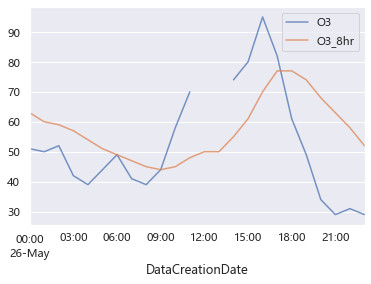

In [135]:
date_lst = [datetime.date(2021,5,26)]
mask =  (df_pic_for_min["date"].isin(date_lst)) 
df_hour_for_plot = df_pic_for_min[mask].sort_values(by=["DataCreationDate"])[["DataCreationDate","O3","O3_8hr"]].set_index('DataCreationDate')
df_hour_for_plot.plot(alpha=0.75)

## 讀取分鐘值資料

In [131]:
path = r"G:\我的雲端硬碟\work\2021\3.環保署_環境即時通專案\110年\3.空品分鐘值資料\馬祖_202100526\rawdata_2021-07-07_17-48-43_0.csv"
df_min = read_data_dir_fPathExt(path)

# 格式轉換
df_min.loc[:, "TIME"] = pd.to_datetime(df_min.loc[:, "TIME"])
df_min.rename(columns={"VALUE":"O3_min","TIME":"DataCreationDate"}, inplace=True)
df_min.loc[:,"O3_min"] = pd.to_numeric(df_min.loc[:,"O3_min"])

df_min.info()

  >> 讀取:: G:\我的雲端硬碟\work\2021\3.環保署_環境即時通專案\110年\3.空品分鐘值資料\馬祖_202100526\rawdata_2021-07-07_17-48-43_0.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1381 entries, 0 to 1380
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DEVICE_ID         1381 non-null   int64         
 1   LON               1381 non-null   float64       
 2   LAT               1381 non-null   float64       
 3   DataCreationDate  1381 non-null   datetime64[ns]
 4   SENSOR(UNIT)      1381 non-null   object        
 5   O3_min            1381 non-null   float64       
 6   ValueRaw          1381 non-null   float64       
 7   Status            1381 non-null   int64         
 8   ValueSD           1381 non-null   int64         
 9   CollectRate       1381 non-null   float64       
 10  Valid             1381 non-null   int64         
 11  ERRORSTATE        0 non-null      float64       
dtypes: datetime64[ns](1), floa

<AxesSubplot:xlabel='DataCreationDate'>

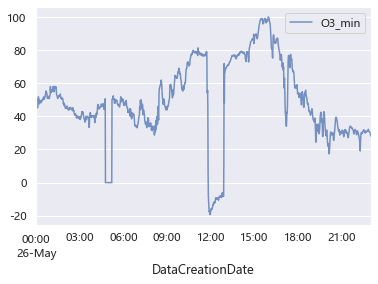

In [134]:
df_min_for_plot = df_min.sort_values(by=["DataCreationDate"])[["DataCreationDate","O3_min"]].set_index('DataCreationDate')
df_min_for_plot.plot(alpha=0.75)

## 疊圖 

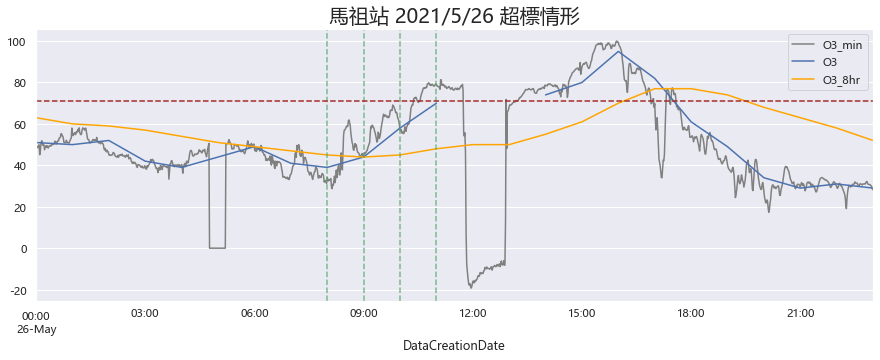

In [133]:
# 分鐘值 df_hour_for_plot   
# 小時值 df_min_for_plot

# 疊圖
fig, ax = plt.subplots(figsize=(15,5))
df_min_for_plot.plot(ax=ax, color='gray')
df_hour_for_plot.plot(ax=ax, color=['b','orange'])
ax.set_title(f"馬祖站 2021/5/26 超標情形", fontsize=20)
for hour in range(8,11+1):
    ax.axvline(datetime.datetime(2021,5,26,hour,0,0), 0,1, color='g',alpha=0.75).set_linestyle("--") # 小時輔助線
ax.axhline(71, 0,1, color='brown').set_linestyle("--") # 閾值輔助線 

> 假設閾值 71， 小時值: 11點達到、分鐘值 10:30達到

## 計算測站 O3小時值缺值情況 

In [4]:
# 篩選測站 & 篩選年分
site_lst = ["新店", "板橋", "古亭", "南投","竹山","埔里", "屏東","潮州","小港"]
year_pic = 2019
pic_mask = (df["SiteName"].isin(site_lst)) & (df["DataCreationDate"].dt.year==year_pic)
df_pic_for_check_nan = df[pic_mask].reset_index(drop=True)
df_pic_for_check_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78813 entries, 0 to 78812
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   index             78813 non-null  int64         
 1   SiteName          78813 non-null  object        
 2   County            78813 non-null  object        
 3   AQI               76776 non-null  float64       
 4   Pollutant         41123 non-null  object        
 5   Status            78813 non-null  object        
 6   SO2               76159 non-null  float64       
 7   CO                76594 non-null  float64       
 8   O3                76452 non-null  float64       
 9   O3_8hr            77576 non-null  float64       
 10  PM10              75324 non-null  float64       
 11  PM2.5             73922 non-null  float64       
 12  NO2               75477 non-null  float64       
 13  NOx               75477 non-null  float64       
 14  NO                7547

In [122]:
df_pic_for_check_nan.loc[:, "is_O3_nan"] = df_pic_for_check_nan.loc[:, "O3"].isnull()
df_pic_for_check_nan.loc[:, "hour"] = df_pic_for_check_nan.loc[:, "DataCreationDate"].dt.hour 

mask_nan = df_pic_for_check_nan.loc[:, "is_O3_nan"].isin([True])
pd.pivot_table(df_pic_for_check_nan, index = ["SiteName", "hour"], values = ["is_O3_nan"], aggfunc = "sum").reset_index()


,SiteName,hour,is_O3_nan
0,南投,0,18
1,南投,1,17
2,南投,2,19
3,南投,3,17
4,南投,4,20
...,...,...,...
211,竹山,19,9
212,竹山,20,5
213,竹山,21,4
214,竹山,22,6


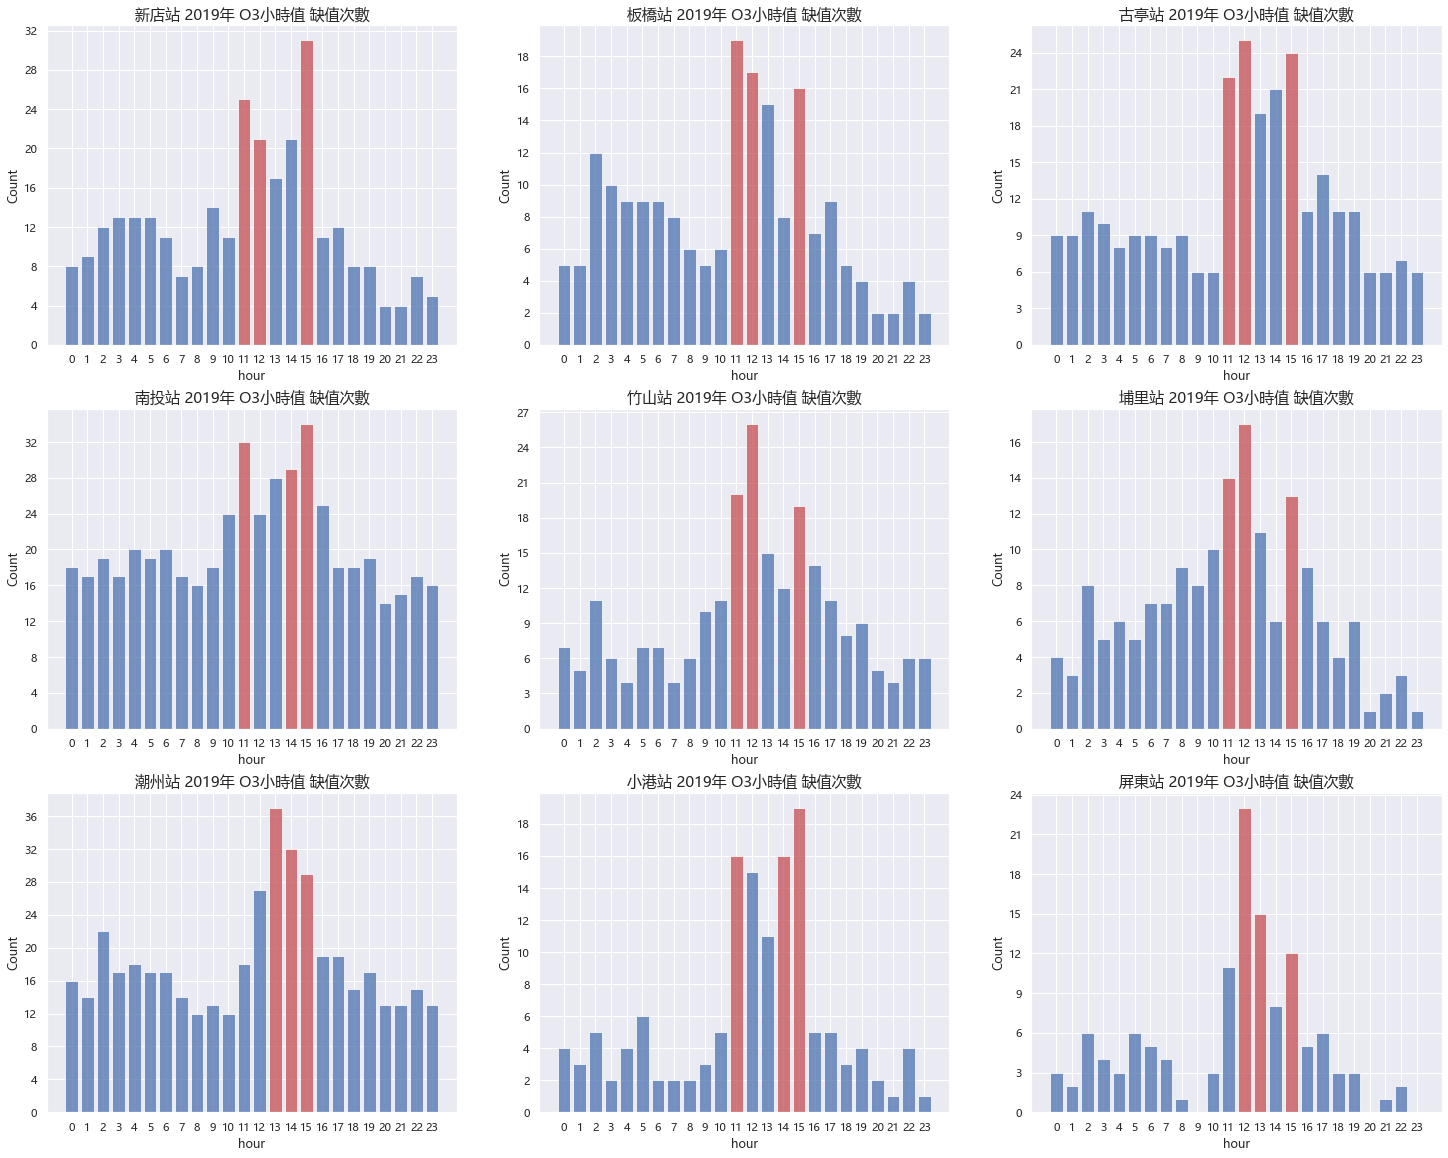

In [151]:
df_pic_for_check_nan.loc[:, "is_O3_nan"] = df_pic_for_check_nan.loc[:, "O3"].isnull()
df_pic_for_check_nan.loc[:, "hour"] = df_pic_for_check_nan.loc[:, "DataCreationDate"].dt.hour 

df_pivot_for_plot = pd.pivot_table(df_pic_for_check_nan, index = ["SiteName", "hour"], values = ["is_O3_nan"], aggfunc = "sum").reset_index()

site_lst = ["新店", "板橋", "古亭", "南投","竹山","埔里","潮州","小港","屏東"]

#組圖
ncol = 3 # 一排幾張圖
nrows = math.ceil(len(site_lst)/ncol)
top = 3 # 特別標記

fig, ax = plt.subplots(nrows=nrows, ncols=ncol, figsize=(25,20))
# for idx, site in enumerate(site_lst):
for idx, site in enumerate(site_lst):
    row = math.floor(idx/ncol)
    col = idx % ncol
    
    site_mask = df_pivot_for_plot.loc[:, "SiteName"].isin([site])
    top_hour = df_pivot_for_plot[site_mask].set_index("hour").sort_values(by=["is_O3_nan"], ascending=0).head(top).index.values
    color = ['b' if h not in top_hour else 'r' for h in range(0,23+1)]
    data = df_pivot_for_plot[site_mask].set_index("hour")
    
    ax[row,col].bar(x=data.index, height=data.is_O3_nan ,alpha=0.75 ,color=color)
    ax[row,col].set_xticks(data.index)
    ax[row,col].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[row,col].set_title(f"{site}站 {year_pic}年 O3小時值 缺值次數", fontsize=15)
    ax[row,col].set_xlabel("hour")
    ax[row,col].set_ylabel("Count")